In [1]:
import os
import tensorflow as tf
from PIL import Image
from nets import nets_factory
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
CHAR_SET_LEN = 10
IMAGE_HEIGHT, IMAGE_WIDTH = 60, 100
BATCH_SIZE = 1 
TFRECORD_FILE = 'captcha/test.tfrecords'

x = tf.placeholder(tf.float32,[None,224,224])

def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    
    # get filenames(labels)
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                      features = {
                                      'image': tf.FixedLenFeature([],tf.string),
                                      'label0': tf.FixedLenFeature([],tf.int64),
                                      'label1': tf.FixedLenFeature([],tf.int64),
                                      'label2': tf.FixedLenFeature([],tf.int64),
                                      'label3': tf.FixedLenFeature([],tf.int64) 
                                 })
    

    image = tf.decode_raw(features['image'],tf.uint8)    
    image_raw = tf.reshape(image,[224,224])    
    image = tf.reshape(image,[224,224])    
    image = tf.cast(image,tf.float32) / 255.0
    image = tf.subtract(image,0.5)
    image = tf.multiply(image,2.0)
   
    label0 = tf.cast(features['label0'],tf.int32)
    label1 = tf.cast(features['label1'],tf.int32)
    label2 = tf.cast(features['label2'],tf.int32)
    label3 = tf.cast(features['label3'],tf.int32)

    return image, image_raw, label0, label1, label2, label3

INFO:tensorflow:Restoring parameters from ./captcha/models/crack_captcha.model-2000


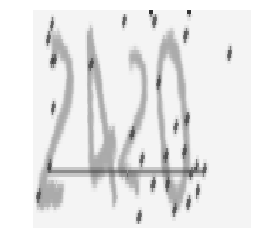

label: [2] [2] [2] [2]
predict: [7] [7] [7] [7]


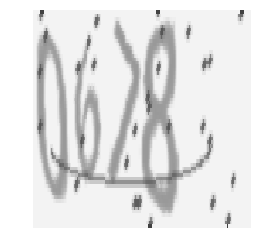

label: [0] [0] [0] [0]
predict: [0] [0] [0] [0]


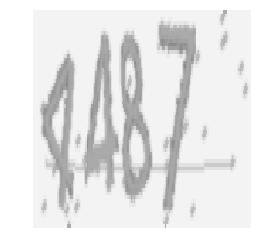

label: [4] [4] [4] [4]
predict: [4] [4] [4] [4]


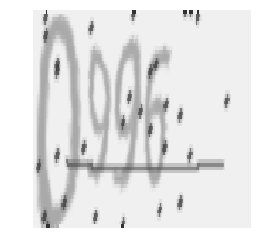

label: [0] [0] [0] [0]
predict: [0] [0] [0] [0]


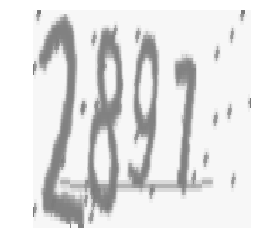

label: [2] [2] [2] [2]
predict: [2] [2] [2] [2]


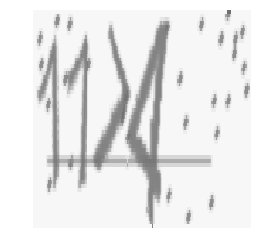

label: [7] [7] [7] [7]
predict: [7] [7] [7] [7]


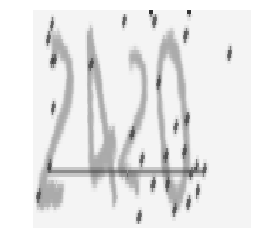

label: [2] [2] [2] [2]
predict: [7] [7] [7] [7]


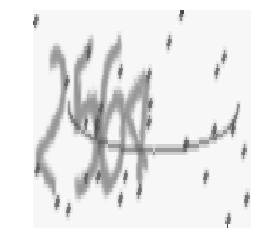

label: [2] [2] [2] [2]
predict: [2] [2] [2] [2]


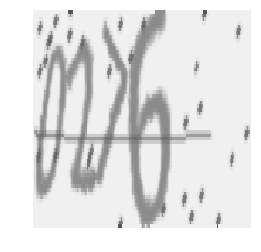

label: [0] [0] [0] [0]
predict: [0] [0] [0] [0]


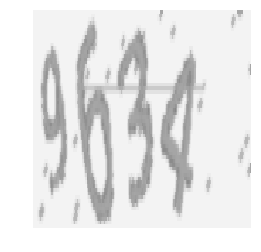

label: [9] [9] [9] [9]
predict: [9] [9] [9] [9]


In [3]:

image, image_raw, label0, label1,label2, label3 = read_and_decode(TFRECORD_FILE)

image_batch, image_raw_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch(
    [image, image_raw, label0, label1,label2,label3], batch_size = BATCH_SIZE,
    capacity = 50000, min_after_dequeue = 10000, num_threads = 1)

#定义网络结构
train_network_fn = nets_factory.get_network_fn(
    'alexnet_v2',
    num_classes = CHAR_SET_LEN,
    weight_decay = 0.0005,
    is_training = False)

with tf.Session() as sess:
    #inputs: a tensor of size[batch_size, height, width,channels]
    X = tf.reshape(x,[BATCH_SIZE, 224, 224, 1])
    #数据输入到网络中
    logits0, logits1, logits2, logits3, end_points = train_network_fn(X)

    #预测值
    predict0 = tf.reshape(logits0, [-1, CHAR_SET_LEN])
    predict0 = tf.argmax(predict0,1)
    
    predict1 = tf.reshape(logits1, [-1, CHAR_SET_LEN])
    predict1 = tf.argmax(predict1,1)

    predict2 = tf.reshape(logits2, [-1, CHAR_SET_LEN])
    predict2 = tf.argmax(predict2,1)

    predict3 = tf.reshape(logits3, [-1, CHAR_SET_LEN])
    predict3 = tf.argmax(predict3,1)

    #初始化
    sess.run(tf.global_variables_initializer())
    
    #载入训练好的模型
    saver = tf.train.Saver()
    saver.restore(sess,'./captcha/models/crack_captcha.model-2000')

    #创建一个协调器，管理线程
    coord = tf.train.Coordinator()
    # 启动QueueRunner, 此时文件名队列已经进队
    threads = tf.train.start_queue_runners(sess = sess, coord = coord)

    for i in range(10):
        b_image, b_image_raw, b_label0, b_label1, b_label2, b_label3 = sess.run([image_batch,
                                                                    image_raw_batch,
                                                                    label_batch0,
                                                                    label_batch1,
                                                                    label_batch2,
                                                                    label_batch3])
        img = Image.fromarray(b_image_raw[0], 'L')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print('label:', b_label0, b_label1, b_label2, b_label3)
        label0,label1,label2,label3 = sess.run([predict0,predict1,predict2,predict3], feed_dict = {x:b_image})
        print('predict:',label0, label1, label2, label3)

    #通知其他线程关闭
    coord.request_stop()
    # 其他所有的线程关闭后，这一函数才能返回
    coord.join(threads)
